## Introduction

### Group members

* Khater, Yara
* Castillo, Galo
* Guaranda, María Belén

In [3]:
from pathlib import Path

import gensim
import gensim.downloader as gensim_api
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import wordcloud
from sklearn import (
    decomposition,
    ensemble,
    feature_extraction,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
)
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from collections import Counter

import time
from lightgbm import LGBMClassifier
import transformers
from transformers import BertModel, BertTokenizerFast, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import TensorDataset, DataLoader

from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import re
import string
import nlpaug.augmenter.word.context_word_embs as aug
from sklearn.utils import shuffle
import fastText 
import os
from fasttext import train_supervised
from sklearn import metrics

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/galo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
sns.set_style("darkgrid")
sns.set_context("notebook")

tqdm.pandas()

%config InlineBackend.figure_format="retina"  # For high DPI display
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

plt.rcParams['figure.dpi'] = 90
plt.rcParams['figure.figsize'] = (11, 7)

%config InlineBackend.figure_format="retina"  # For high DPI display

cpu


In [11]:

#FILENAME = 'Reviews_small.csv.xz'
FILENAME = 'Reviews.csv'

#DATA = Path("archive")
DATA = Path("./../../M1_Classes/hands_on_nlp/final_project/archive")

assert DATA.is_dir()

#IMG = Path("img")
IMG = Path("./../../M1_Classes/hands_on_nlp/final_project/img")

assert IMG.is_dir()

In [12]:
df = pd.read_csv(DATA / FILENAME)
df.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

* Contains some product, user, and review information

* Data used here:

    * Text: Complete product review by the customer
    * Summary: Summary proposed by the customer
    * Score: The product rating provided by the customer

In [13]:
dim_ini = df.shape[0]
df.drop_duplicates(['Text', 'Summary'], inplace=True, keep='first')
dim = df.shape[0]
print(f"{dim / dim_ini:.2%}, raw_dim: {dim_ini:,}, dim: {dim:,}")

69.48%, raw_dim: 568,454, dim: 394,970


In [14]:
num_entries = df.shape[0]
nulls_summary = df["Summary"].isnull().sum()
nulls_text = df["Text"].isnull().sum()

print("There are %9d entries in our dataset.\nThere are %3d null values for the Summary column, and %2d null values for the Text column." % (num_entries, nulls_summary, nulls_text))

There are    394970 entries in our dataset.
There are   3 null values for the Summary column, and  0 null values for the Text column.


In [15]:
# Checking if there are duplicated rows (taking into account all the columns)
print("There are %d duplicated rows" % df.duplicated().sum())

#Now check duplicates of texts
print("There are %d duplicated texts." % df.duplicated(subset=["Summary","Text"]).sum())

There are 0 duplicated rows
There are 0 duplicated texts.


### Analysis 3-classes versions

In [16]:
def convert_rating(rating, threshold=3):
    if rating > threshold:
        return 1
    if rating < threshold:
        return -1
    return 0

In [17]:
df["sentiment"] = df.Score.map(convert_rating)

This is the new distribution of the target variable sentiment

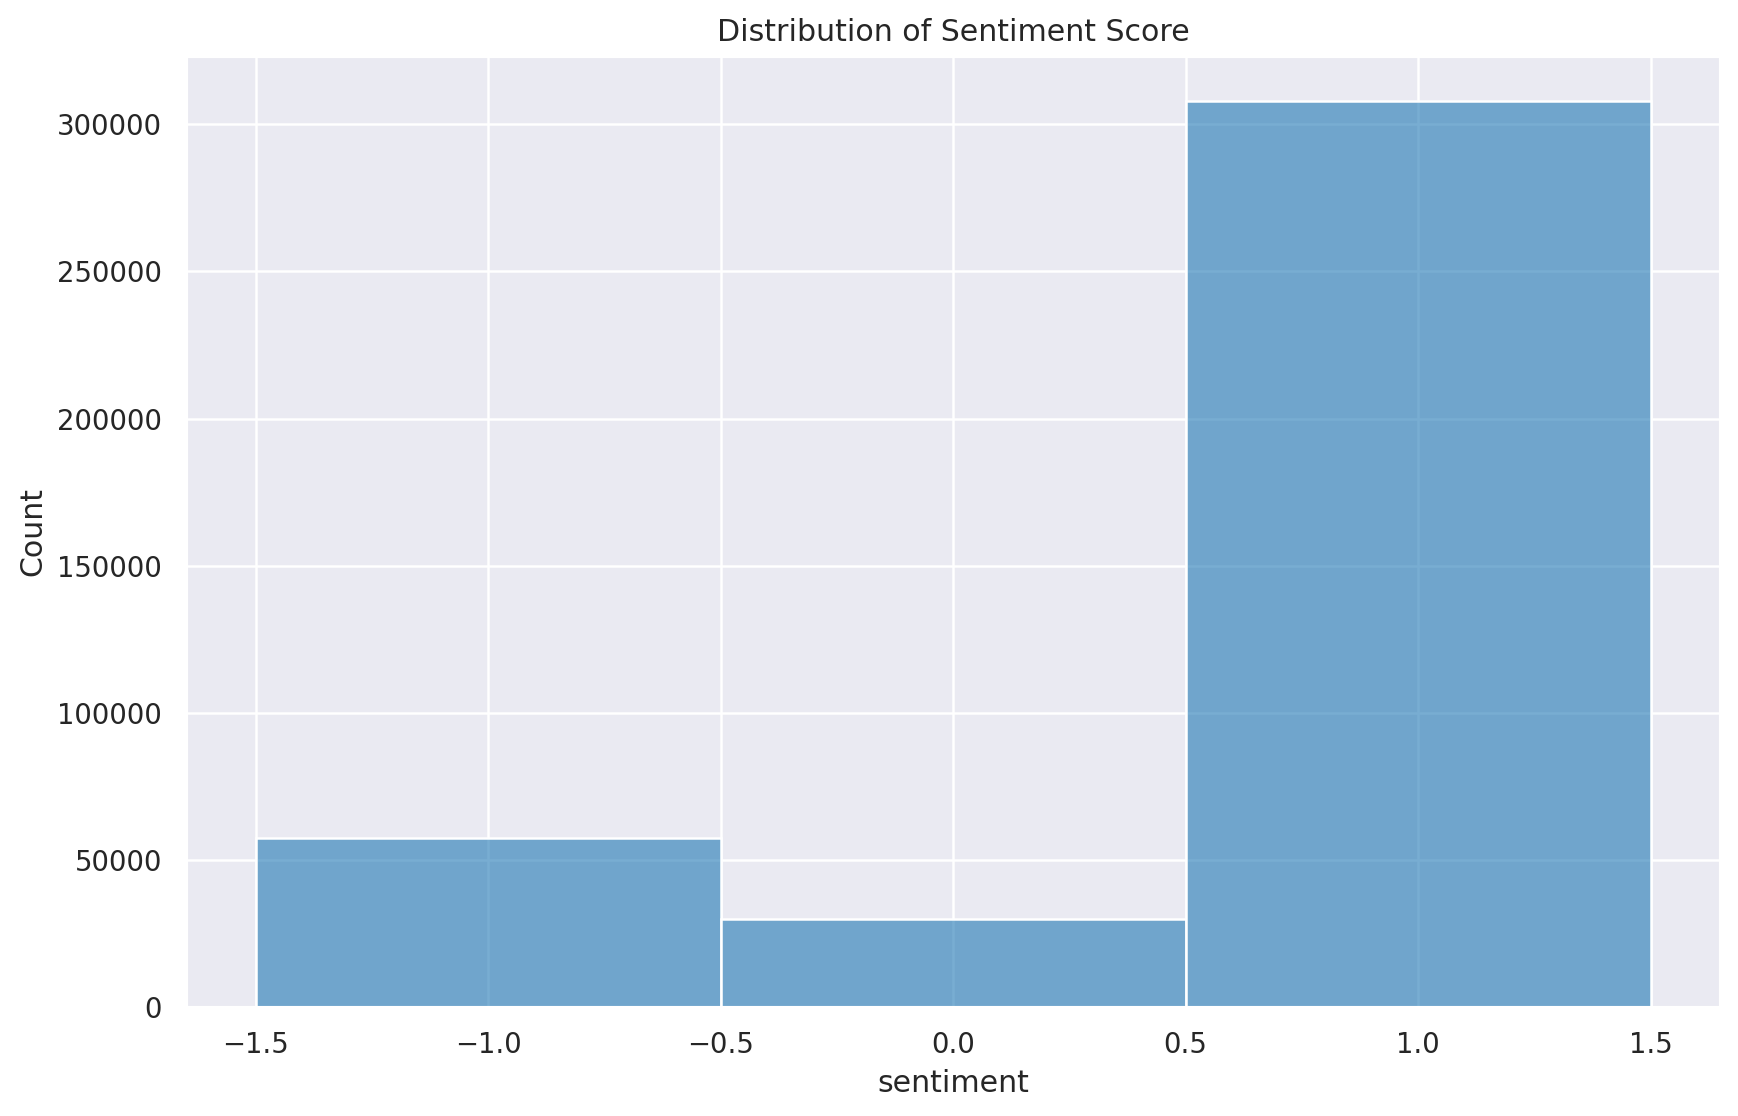

In [19]:
sns.histplot(df, x="sentiment", alpha=0.6, discrete=True)
plt.title('Distribution of Sentiment Score')
plt.show()

In [20]:
100*df.sentiment.value_counts(normalize=True)

 1    77.926678
-1    14.519077
 0     7.554245
Name: sentiment, dtype: float64

We can see that there is a class imbalance problem. Where most of the data consists of positive reviews.

In [21]:
df.describe()

Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  394970.000000         394970.000000           394970.000000   
mean   261544.868960              1.734073                2.205137   
std    167039.910688              6.870629                7.533882   
min         1.000000              0.000000                0.000000   
25%    112826.250000              0.000000                0.000000   
50%    248988.500000              0.000000                1.000000   
75%    407289.750000              2.000000                2.000000   
max    568454.000000            866.000000              923.000000   

               Score          Time      sentiment  
count  394970.000000  3.949700e+05  394970.000000  
mean        4.178659  1.296461e+09       0.634076  
std         1.312818  4.838135e+07       0.722777  
min         1.000000  9.393408e+08      -1.000000  
25%         4.000000  1.271376e+09       1.000000  
50%         5.000000  1.311638e+09       1.000000  
75%         5.000000  1.332979e+09       1.000000  
max         5.000000  1.351210e+09       1.000000

### Words distribution

In [23]:
def clean_text(text, remove_stopwords=True, lemmatize=True):
    
    lmtzr = WordNetLemmatizer()
    clean_text = str(text)
    
    clean_text = clean_text.lower().strip()
    clean_text = clean_text.replace('<', ' ').replace('>', ' ') # This helps to remove HTML tags and URLs.
    clean_text = re.sub(r"http\S+", "", clean_text)
    clean_text = re.sub('[^a-zA-Z]', ' ', clean_text)
    clean_text = re.sub(' +', ' ', clean_text)
    if remove_stopwords and lemmatize:
        clean_text = ' '.join([lmtzr.lemmatize(word) for word in clean_text.split() if word not in stopwords])
    elif remove_stopwords:
        clean_text = ' '.join([word for word in clean_text.split() if word not in stopwords])
    elif lemmatize:
        clean_text = ' '.join([lmtzr.lemmatize(word) for word in clean_text.split()])    
    return clean_text

In [22]:
# Create stopword list
stopwords = set(wordcloud.STOPWORDS) | set(
    nltk.corpus.stopwords.words("english")
)
stopwords.update(["br", "href"])

In [24]:
df['clean_summary'] = df['Summary'].apply(lambda x: clean_text(x))
df['clean_text'] = df['Text'].apply(lambda x: clean_text(x))

In [25]:
df[['Text', 'clean_text', 'sentiment']].head()

Text  \
0  I have bought several of the Vitality canned d...   
1  Product arrived labeled as Jumbo Salted Peanut...   
2  This is a confection that has been around a fe...   
3  If you are looking for the secret ingredient i...   
4  Great taffy at a great price.  There was a wid...   

                                          clean_text  sentiment  
0  bought several vitality canned dog food produc...          1  
1  product arrived labeled jumbo salted peanut pe...         -1  
2  confection around century light pillowy citrus...          1  
3  looking secret ingredient robitussin believe f...         -1  
4  great taffy great price wide assortment yummy ...          1

In [26]:
positive_df = df[df.sentiment == 1]
negative_df = df[df.sentiment == -1]

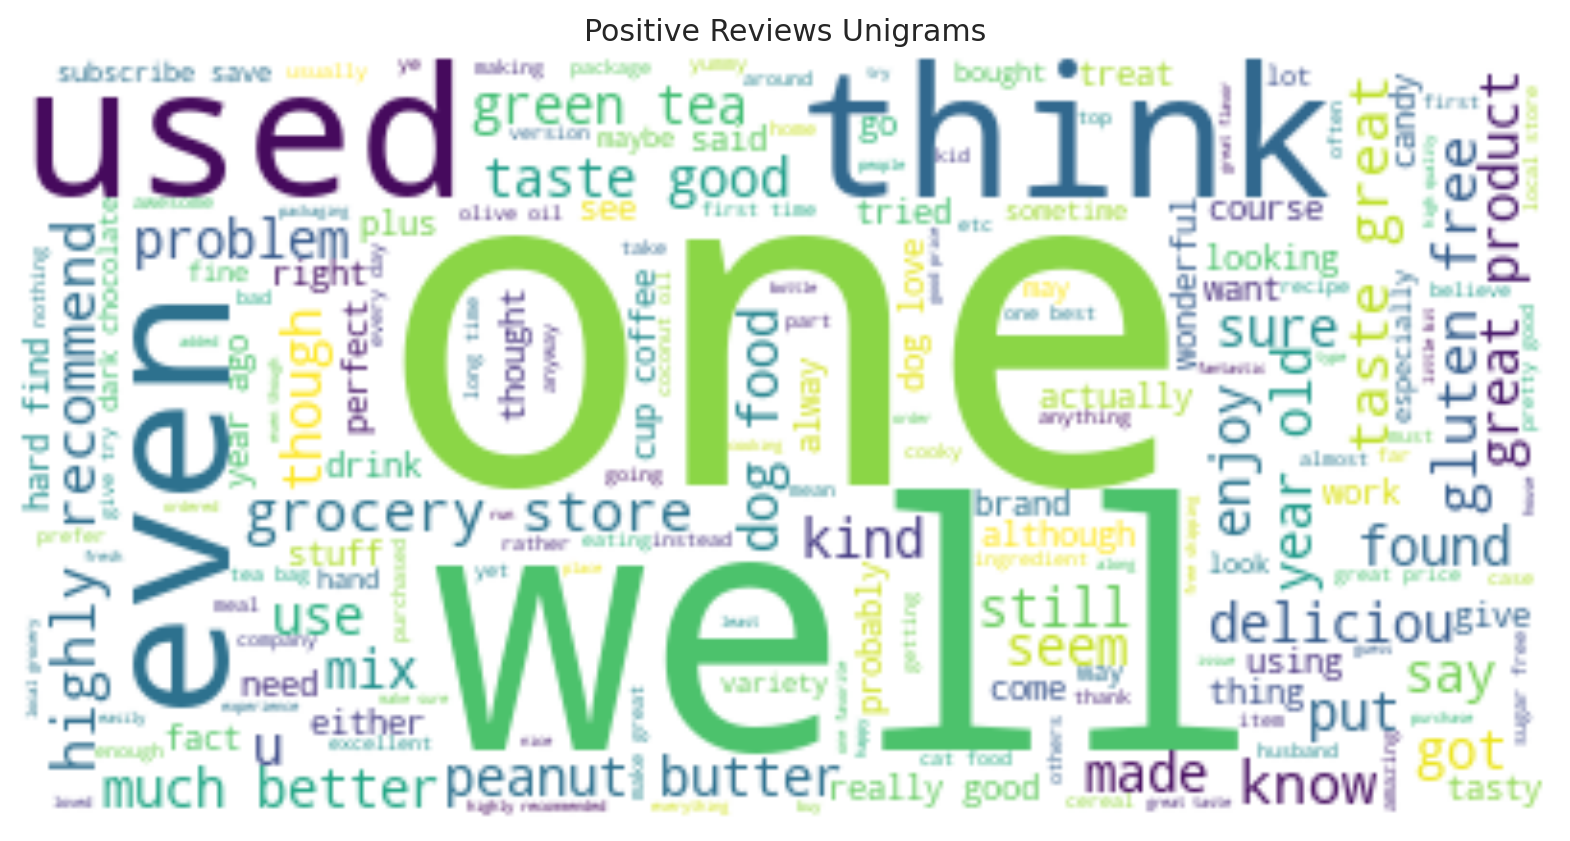

In [29]:
pos_wordcloud = WordCloud(
    stopwords=stopwords,
    background_color="white",
).generate(" ".join(positive_df.clean_text.dropna()))

plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Positive Reviews Unigrams')
plt.show()

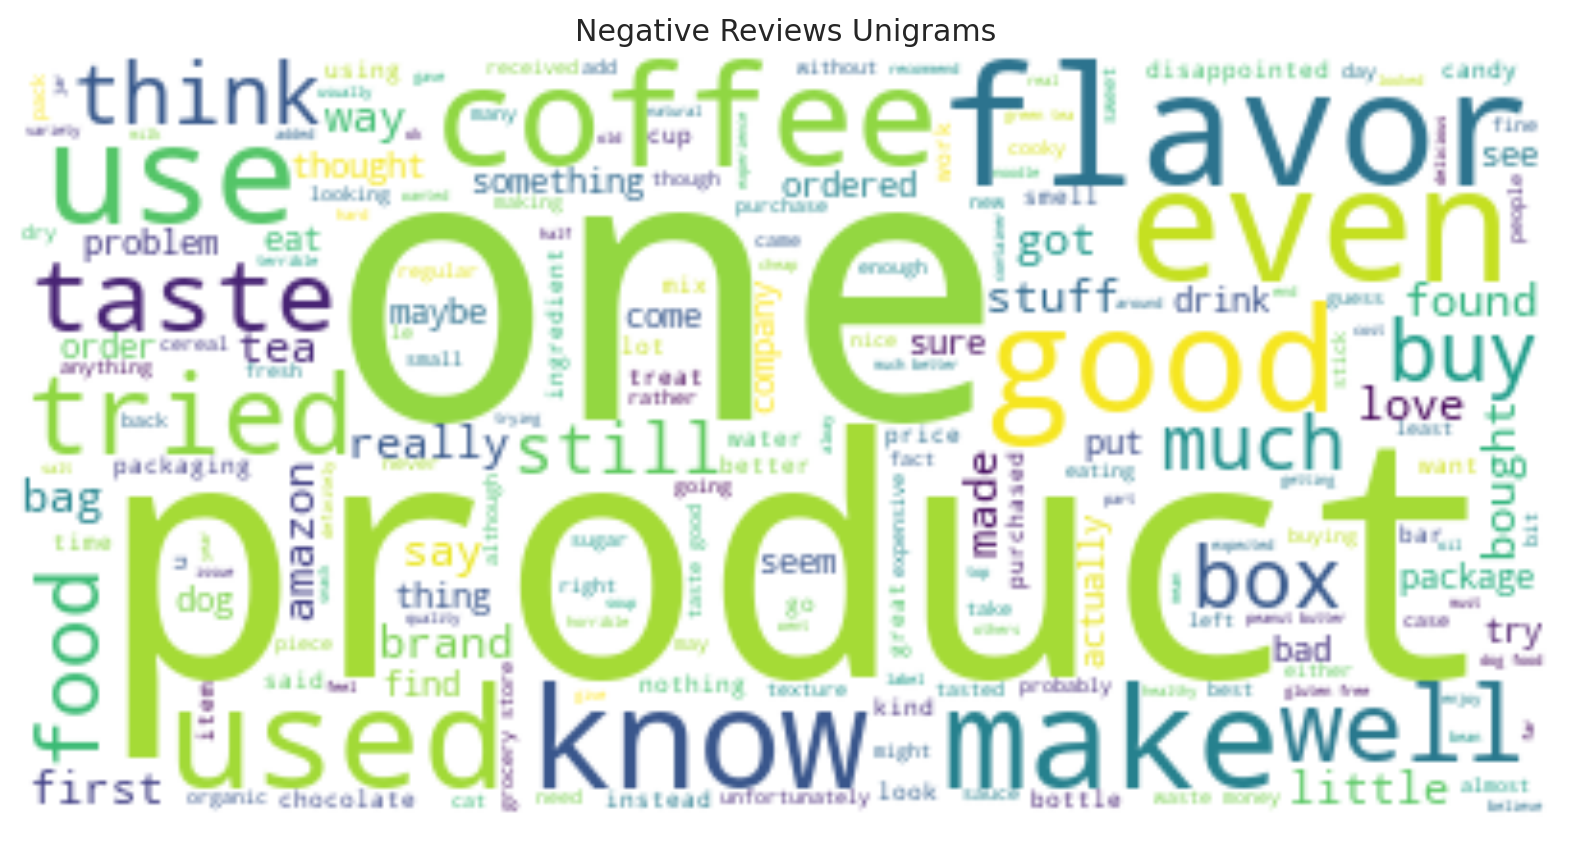

In [30]:
neg_wordcloud = WordCloud(
    stopwords=stopwords,
    background_color="white",
).generate(" ".join(negative_df.clean_text.dropna()))

plt.imshow(neg_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Negative Reviews Unigrams')
plt.show()

* Positive sentiment words, e.g., *love, best, delicious*

* Negative sentiment words, e.g., *disappointed, bad, yuck*

* The word ***good*** appears in the negative sentiment word cloud, despite being a positive word 

    * Probably because it was used in a negative context: ***not good*** 

In [31]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Text(0, 0.5, 'Bigrams')

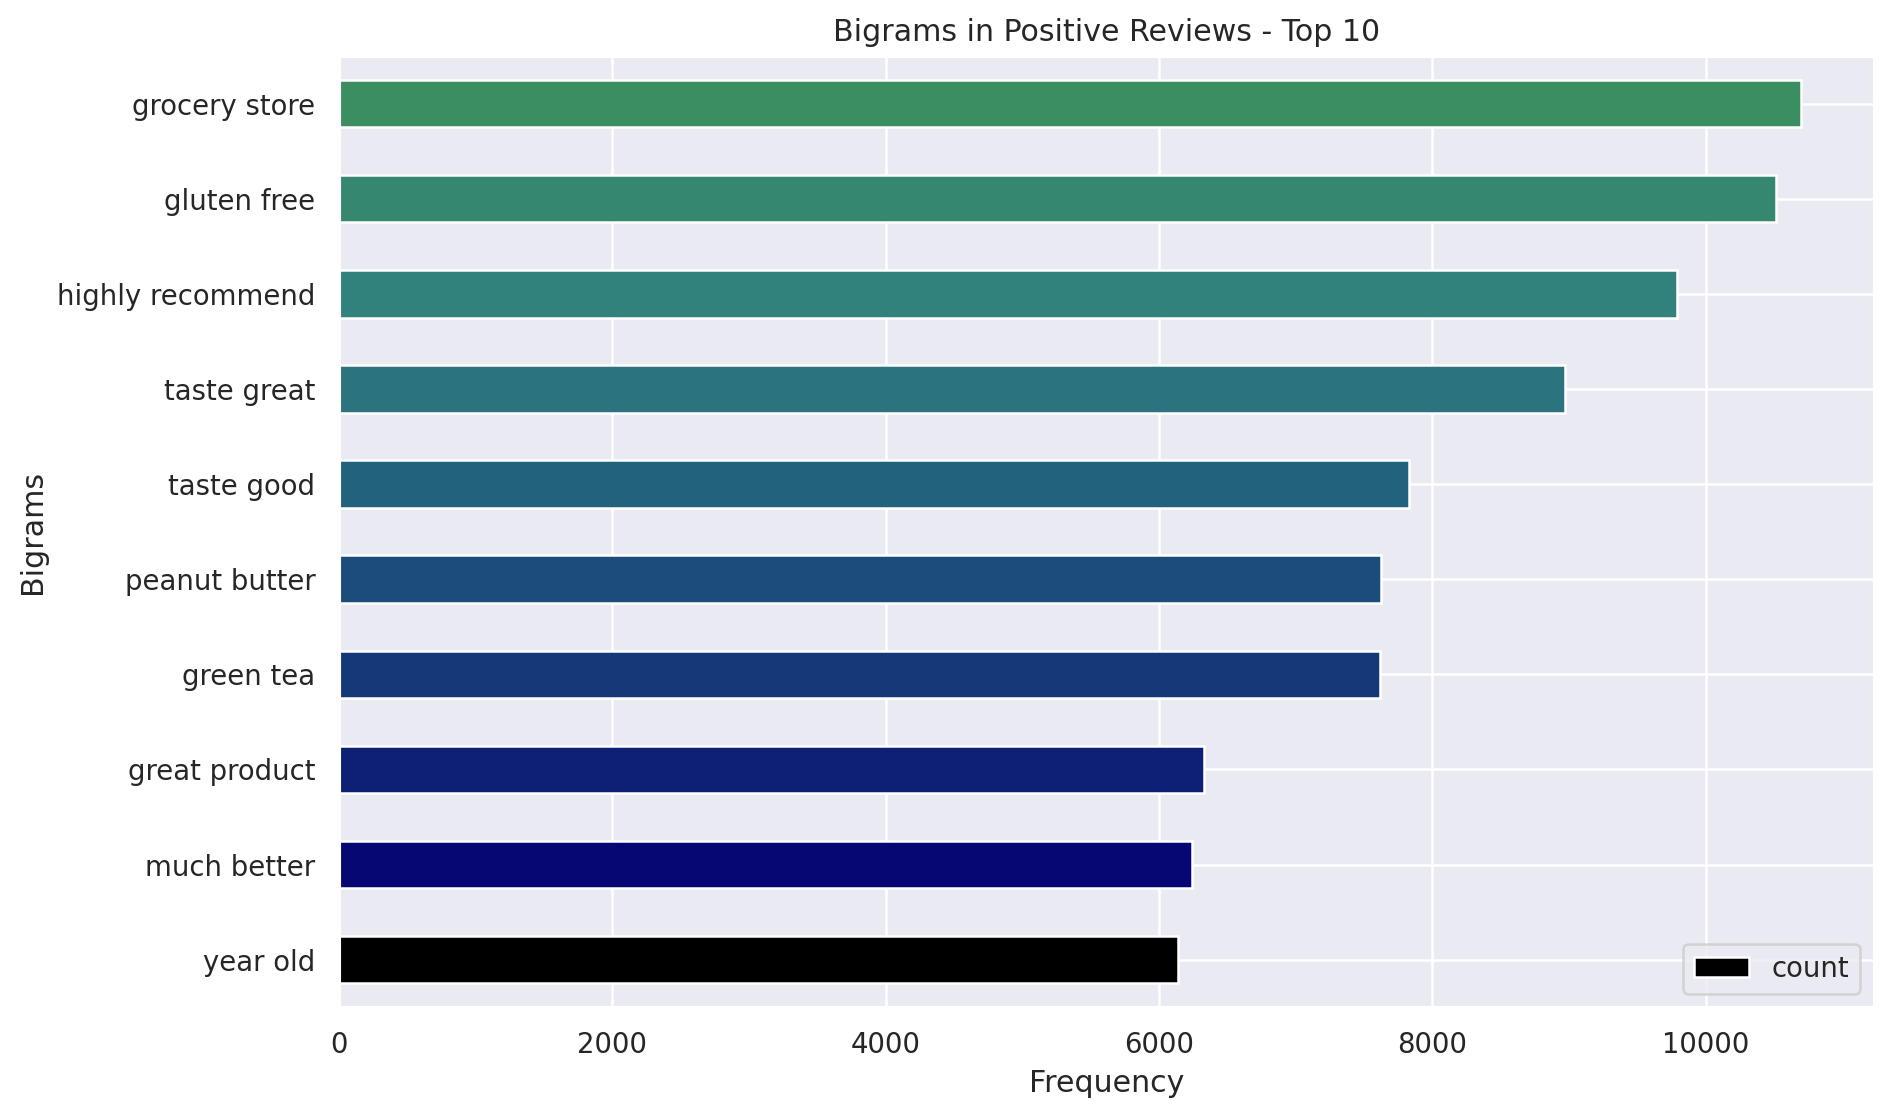

In [32]:
common_words = get_top_n_bigram(positive_df['clean_text'], 10)
df_tmp = pd.DataFrame(common_words, columns = ['bigrams' , 'count'])
color = plt.cm.gist_earth(np.linspace(0, 1, 25))
df_tmp.sort_values('count', ascending=True).plot(x='bigrams', y='count', kind='barh', color=color)
plt.title("Bigrams in Positive Reviews - Top 10")
plt.xlabel('Frequency')
plt.ylabel('Bigrams')

Text(0, 0.5, 'Bigrams')

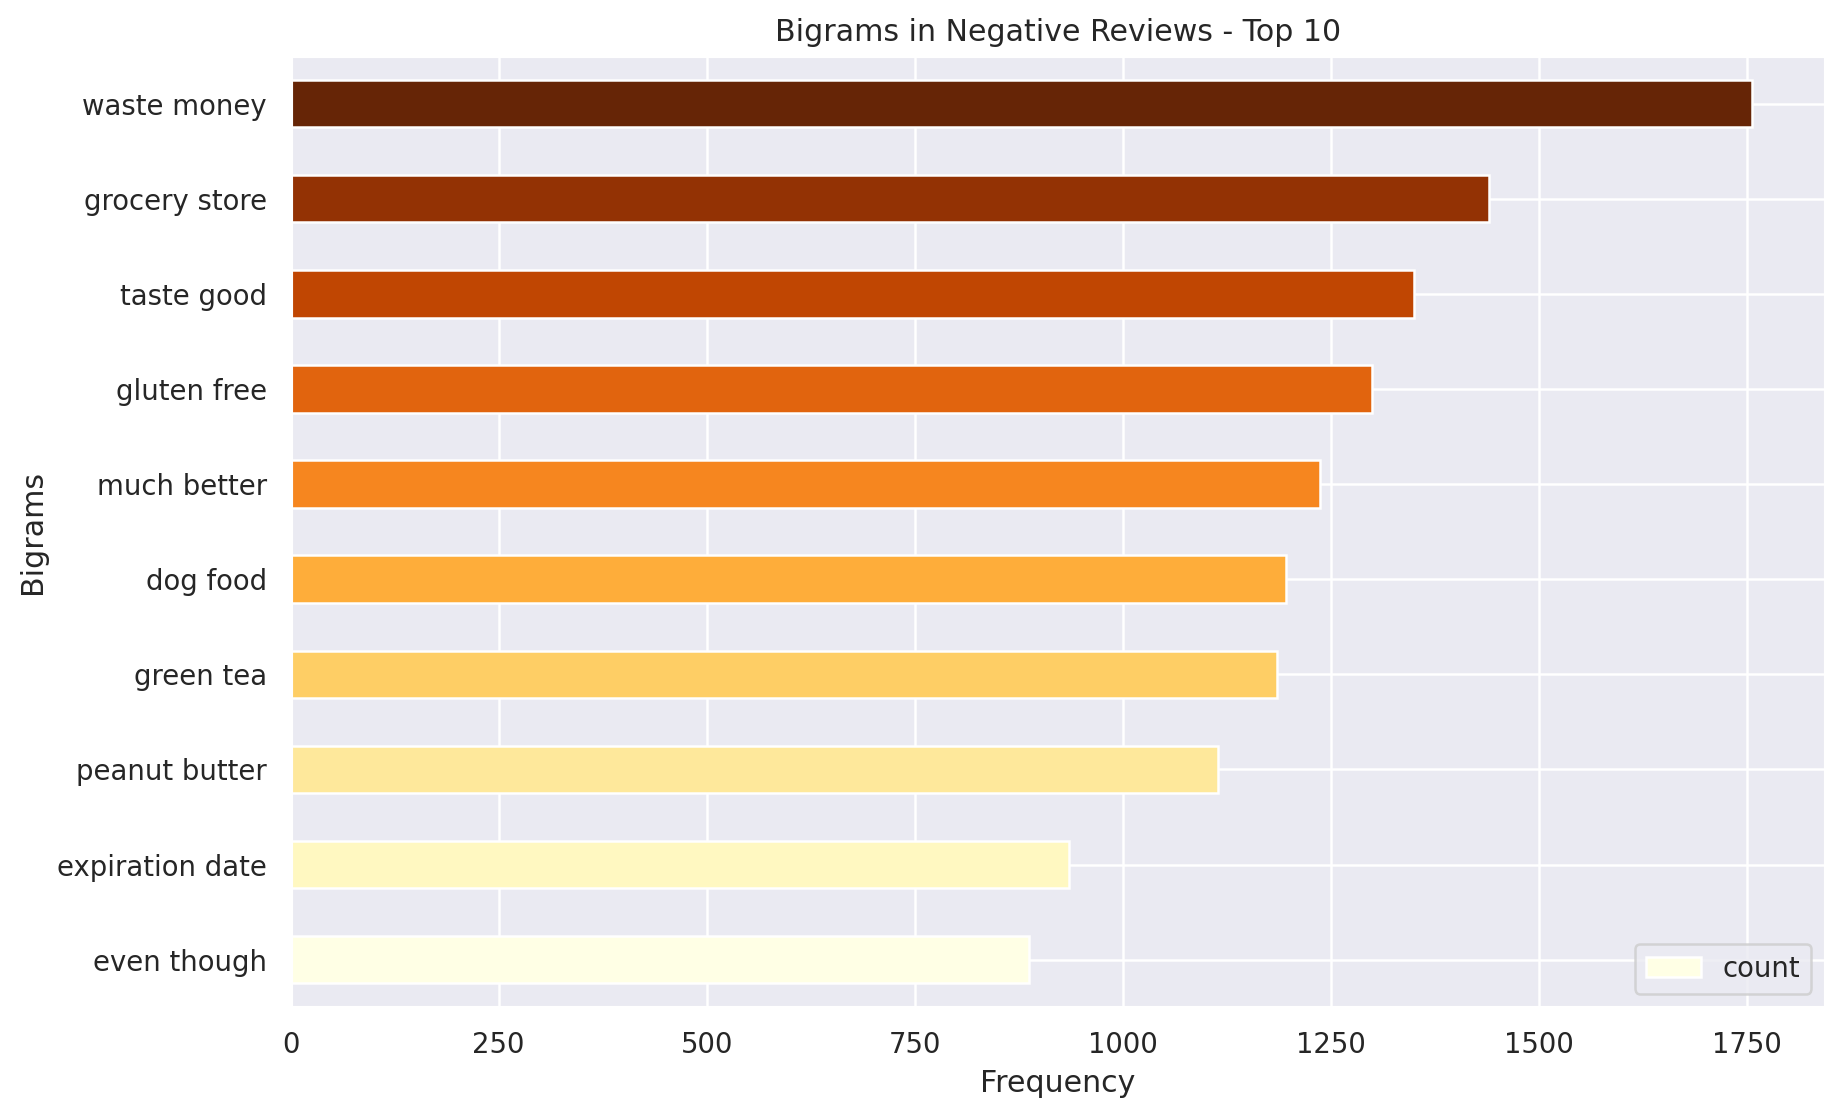

In [33]:
common_words = get_top_n_bigram(negative_df['clean_text'], 10)
df_tmp = pd.DataFrame(common_words, columns = ['bigrams' , 'count'])
color = plt.cm.YlOrBr(np.linspace(0, 1, 10))
df_tmp.sort_values('count', ascending=True).plot(x='bigrams', y='count', kind='barh', color=color)
plt.title("Bigrams in Negative Reviews - Top 10")
plt.xlabel('Frequency')
plt.ylabel('Bigrams')

Why "taste good" is part of the most frequent negative bigrams? Unreached expectations or negations.

**Example 1:**
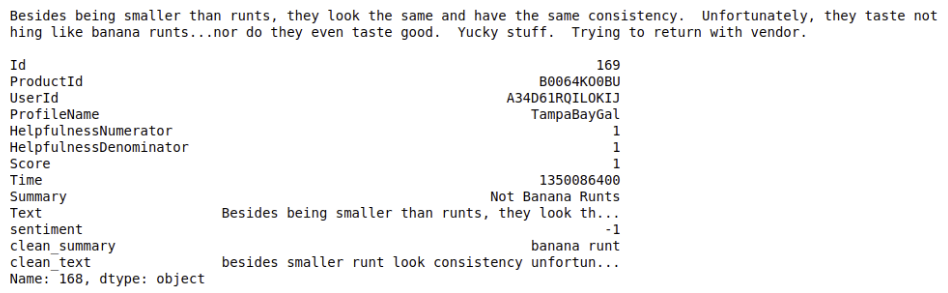

**Example 2:**
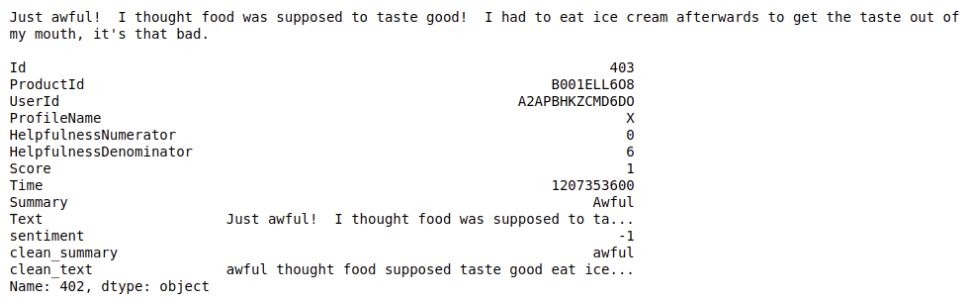

Also, our stopwords set contains words such as *isn't*, so expresions like "the taste *isn't* good" are omitted.

In [34]:
common_words_pos = get_top_n_bigram(positive_df['clean_text'], 50)
common_words_neg = get_top_n_bigram(negative_df['clean_text'], 50)

bigrams_df = pd.DataFrame(common_words_pos + common_words_neg, columns = ['bigrams' , 'count'])

bigrams_df = bigrams_df.groupby(['bigrams'], as_index=False)['count'].agg('sum')

bigrams_df.head(10)

bigrams  count
0       absolutely love   2798
1  artificial sweetener    465
2             bad batch    506
3             black tea   2863
4           buy product    690
5          buyer beware    438
6              cat food   4479
7           coconut oil   3602
8         coconut water    663
9          coffee taste    453

In [35]:
# Create network plot 
G = nx.Graph()
for index, row in bigrams_df.iterrows():
    # Create connections between nodes
    n1 = row['bigrams'].split()[0]
    n2 = row['bigrams'].split()[1]
    w = row['count']
    G.add_edge(n1, n2, weight=(w * 10))

In [36]:
words_negative = set([t[0].split()[0] for t in common_words_neg] + [t[0].split()[1] for t in common_words_neg])
words_positive = set([t[0].split()[0] for t in common_words_pos] + [t[0].split()[1] for t in common_words_pos])
words_common = words_positive & words_negative
nodes_colors = ['limegreen' if node in words_positive - words_common else 'red' if node in words_negative - words_common else 'gray' for node in G.nodes]

We build a co-occurence of terms contained in most frequent bigrams. Each **node** corresponds to a **term** that appears in the the top 50 most frequent bigrams of negative reviews or positive reviews (or maybe both). An edge between two nodes (terms) appears when the two connected nodes form at least one bigram.

- Red colored nodes corresponds to terms that only appear on most frequent bigrams on negative reviews.
- Green colored nodes corresponds to terms that only appear on most frequent bigrams on positive reviews.
- Gray colored nodes corresponds to terms that appear on most frequent bigrams on positive **and** negative reviews.

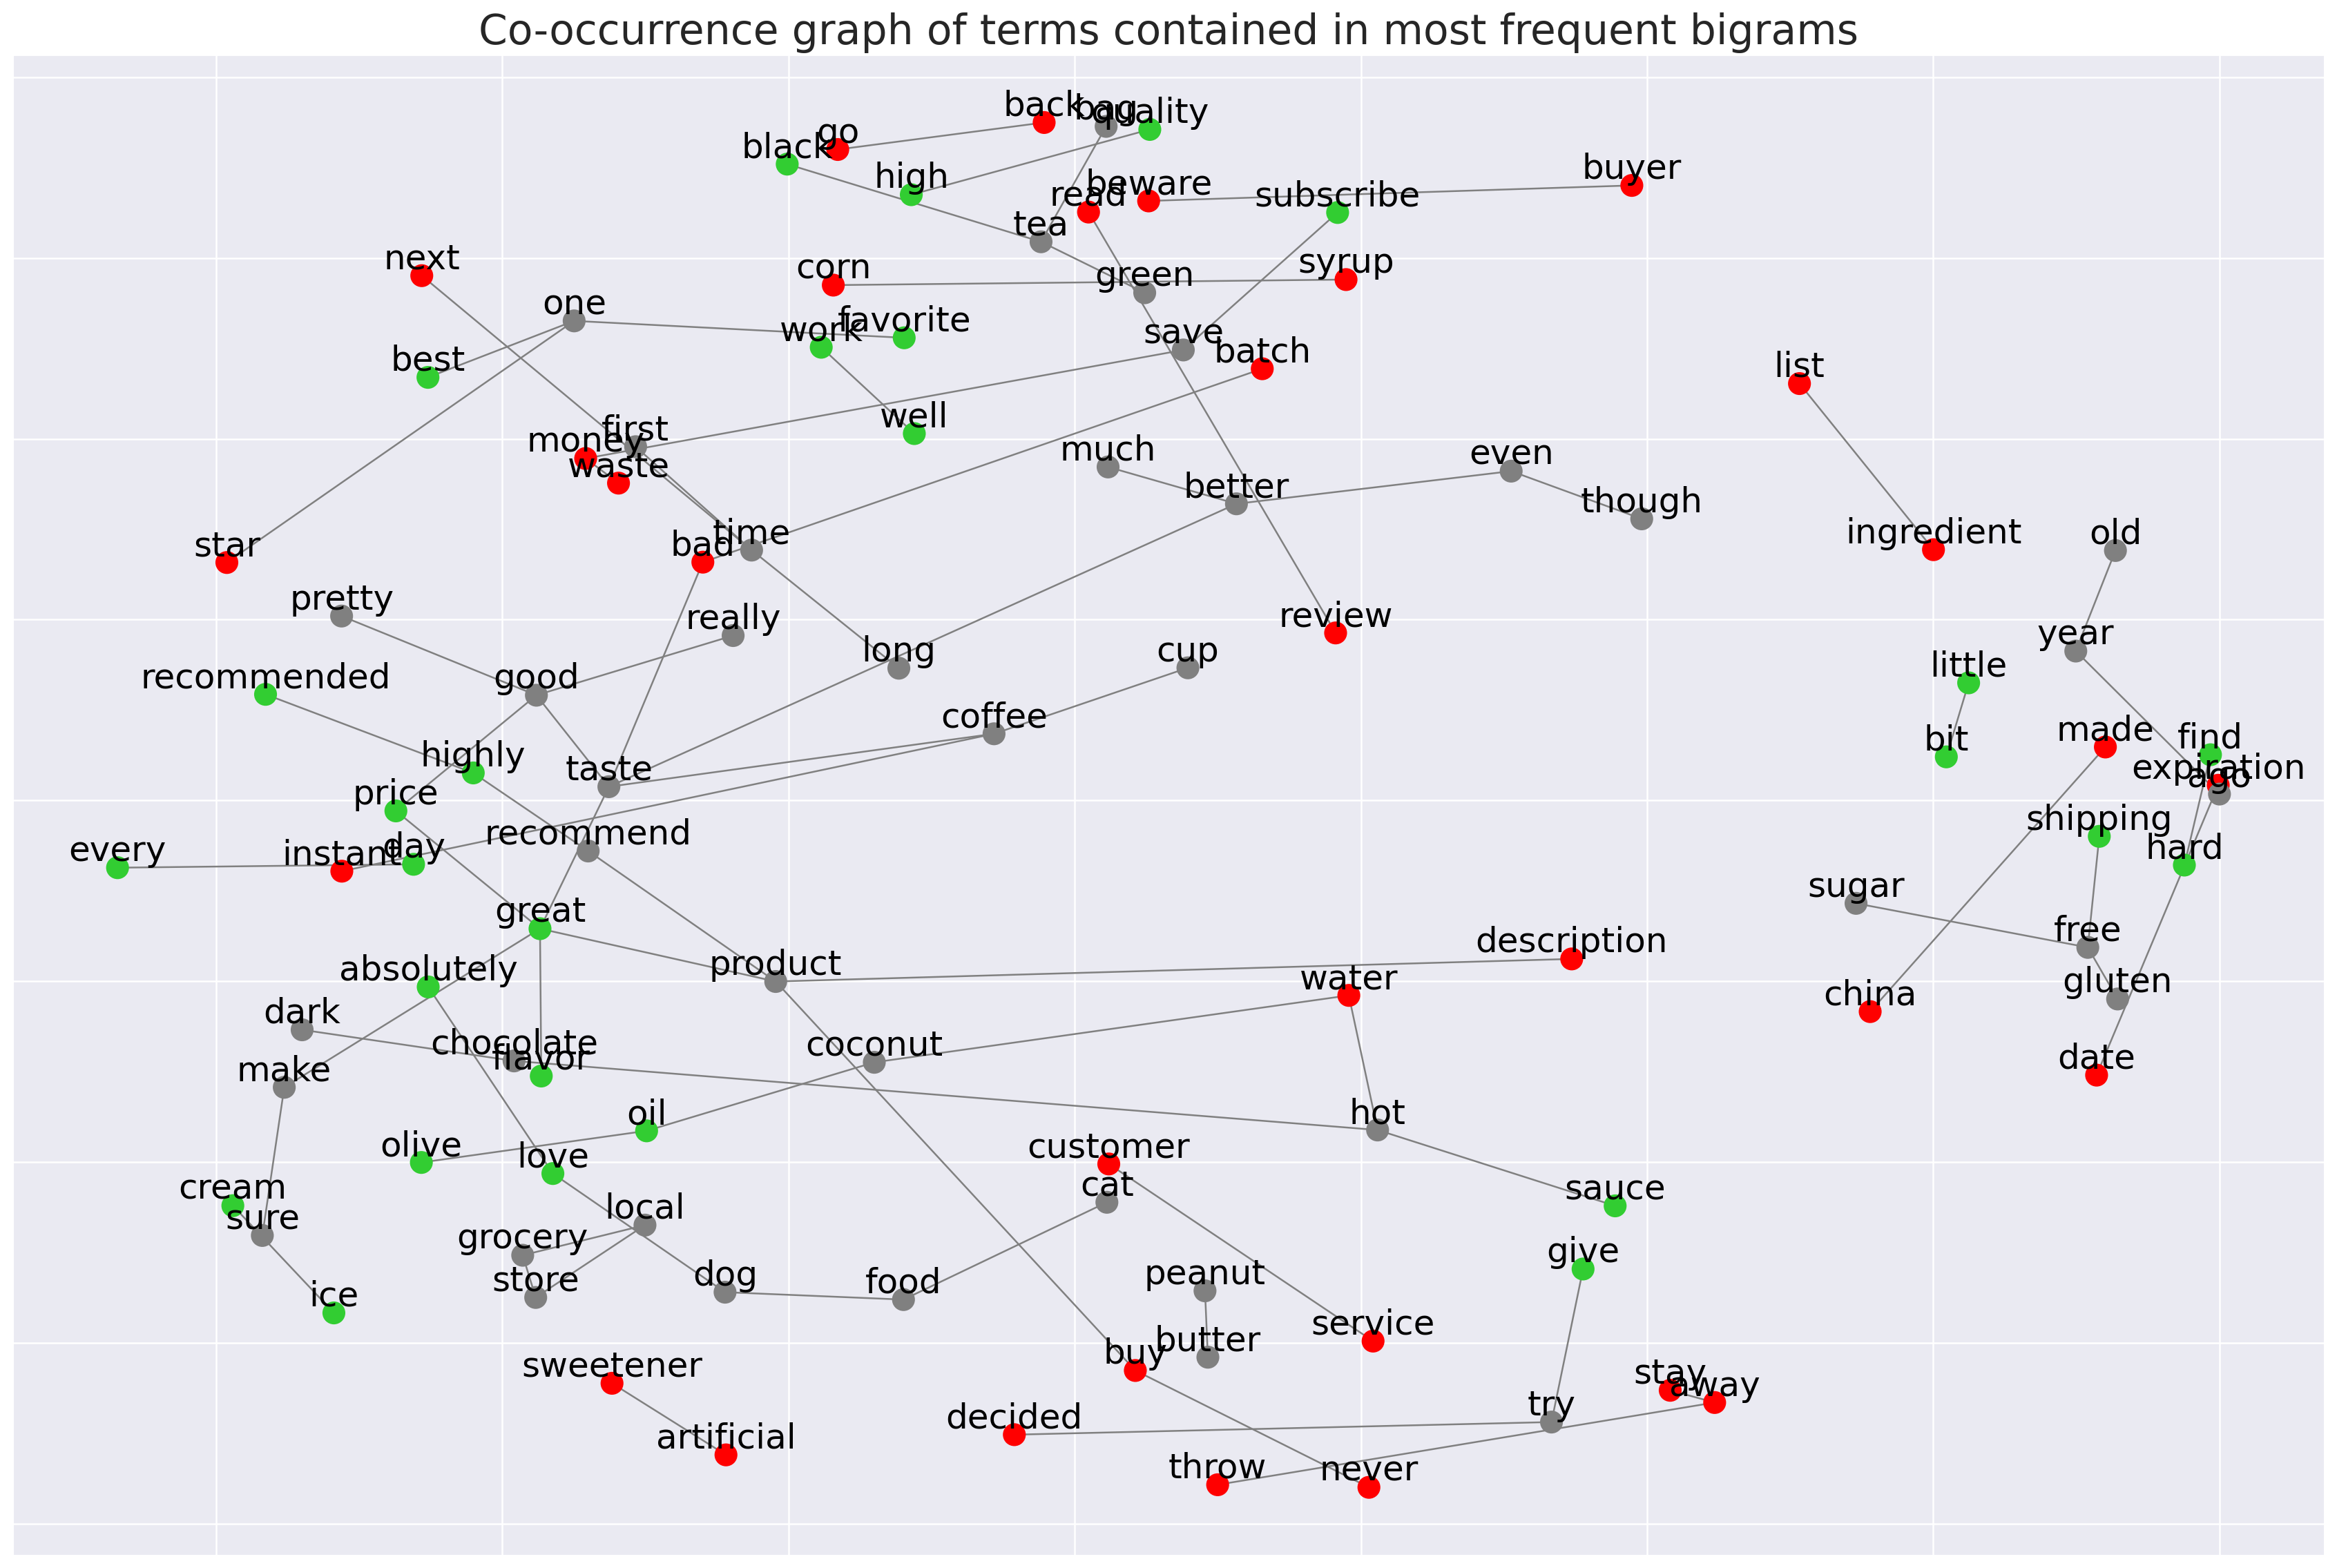

In [37]:
fig, ax = plt.subplots(figsize=(24, 16))

pos = nx.spring_layout(G, k=17, seed=1, iterations=100)
nx.draw_networkx(G, pos,
                 font_size=20,
                 width=1,
                 edge_color='grey',
                 node_color=nodes_colors,
                 node_size=150,
                 with_labels = True,
                 verticalalignment='bottom',
                 ax=ax)    
plt.title('Co-occurrence graph of terms contained in most frequent bigrams', fontsize=24)
plt.show()

In [38]:
df["sentiment_text"] = (
    df.sentiment.replace({-1: "negative", 0: "neutral", 1: "positive"})
    .astype("category")  # To set the x-axis order in sns.histplot
    .cat.reorder_categories(["positive", "neutral", "negative"])
)

### Other Exploratory Data Analysis

In [40]:
df['Summary'] = df['Summary'].astype(str)
df['Text'] = df['Text'].astype(str)

df['summary_tokens_num'] = df['clean_summary'].apply(lambda x: len(x.split()))
df['text_tokens_num'] = df['clean_text'].apply(lambda x: len(x.split()))

df['summary_len'] = df['clean_summary'].apply(lambda x: len(x))
df['text_len'] = df['clean_text'].apply(lambda x: len(x))

Text(0.5, 1.0, 'Distribution of the number of tokens per sentiment category')

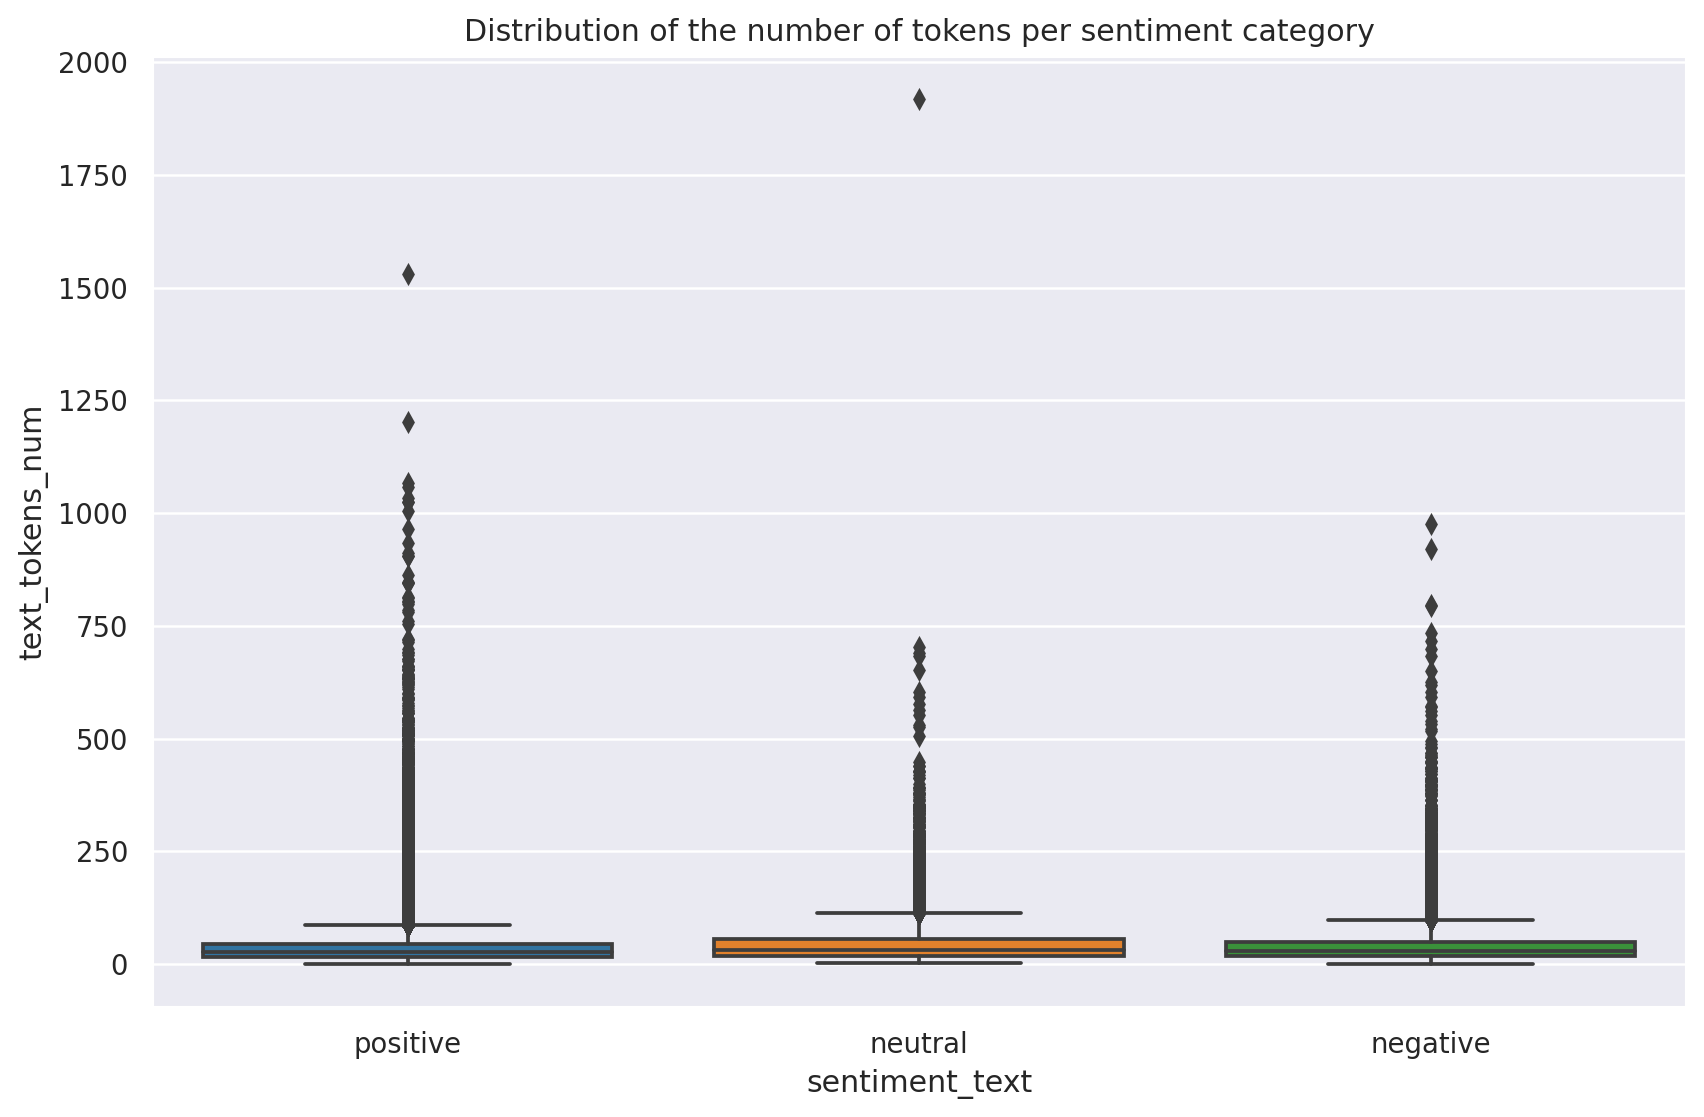

In [41]:
sns.boxplot(x="sentiment_text", y="text_tokens_num", data=df)
plt.title('Distribution of the number of tokens per sentiment category')

Text(0.5, 1.0, 'Distribution of the number of tokens per sentiment category without outliers')

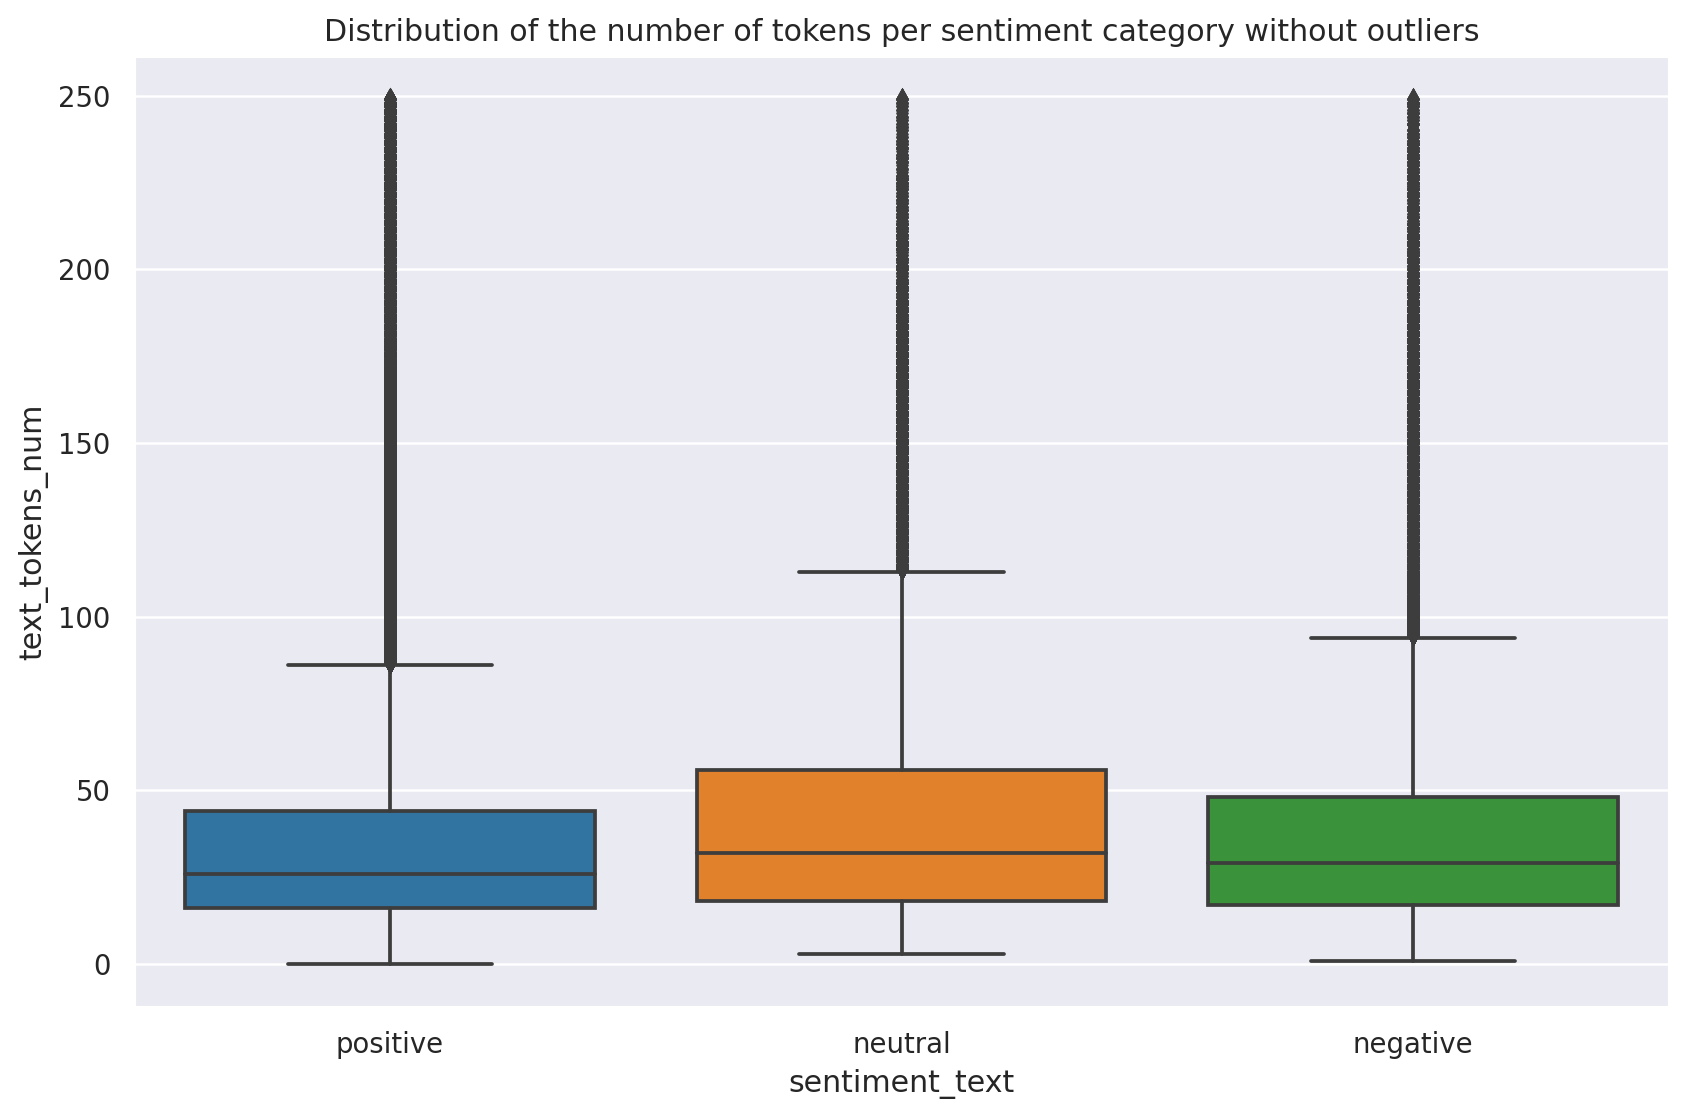

In [43]:
sns.boxplot(x="sentiment_text", y="text_tokens_num", data=df.loc[df['text_tokens_num'] < 250])
plt.title('Distribution of the number of tokens per sentiment category without outliers')

Now we will develop an ScatterText, which will let us gain more understanding on which terms from our corpus are more related to negative or positive.

In [59]:
import scattertext as st
corpus = st.CorpusFromPandas(df.sample(n=3000, replace=False, random_state=0),
                             category_col='sentiment_text',
                             text_col='clean_text').build()

In [60]:
html = st.produce_scattertext_explorer(corpus,
        category='positive',
        category_name='Positive',            
        not_categories=['negative'],
        not_category_name='Negative',
        neutral_categories=['neutral'],
        neutral_category_name='Neutral',
        show_neutral=True,
        show_diagonal=True,        
        width_in_pixels=1000)

In [61]:
file_name = 'reviews_scattertext.html'
open(file_name, 'wb').write(html.encode('utf-8'))

1798396

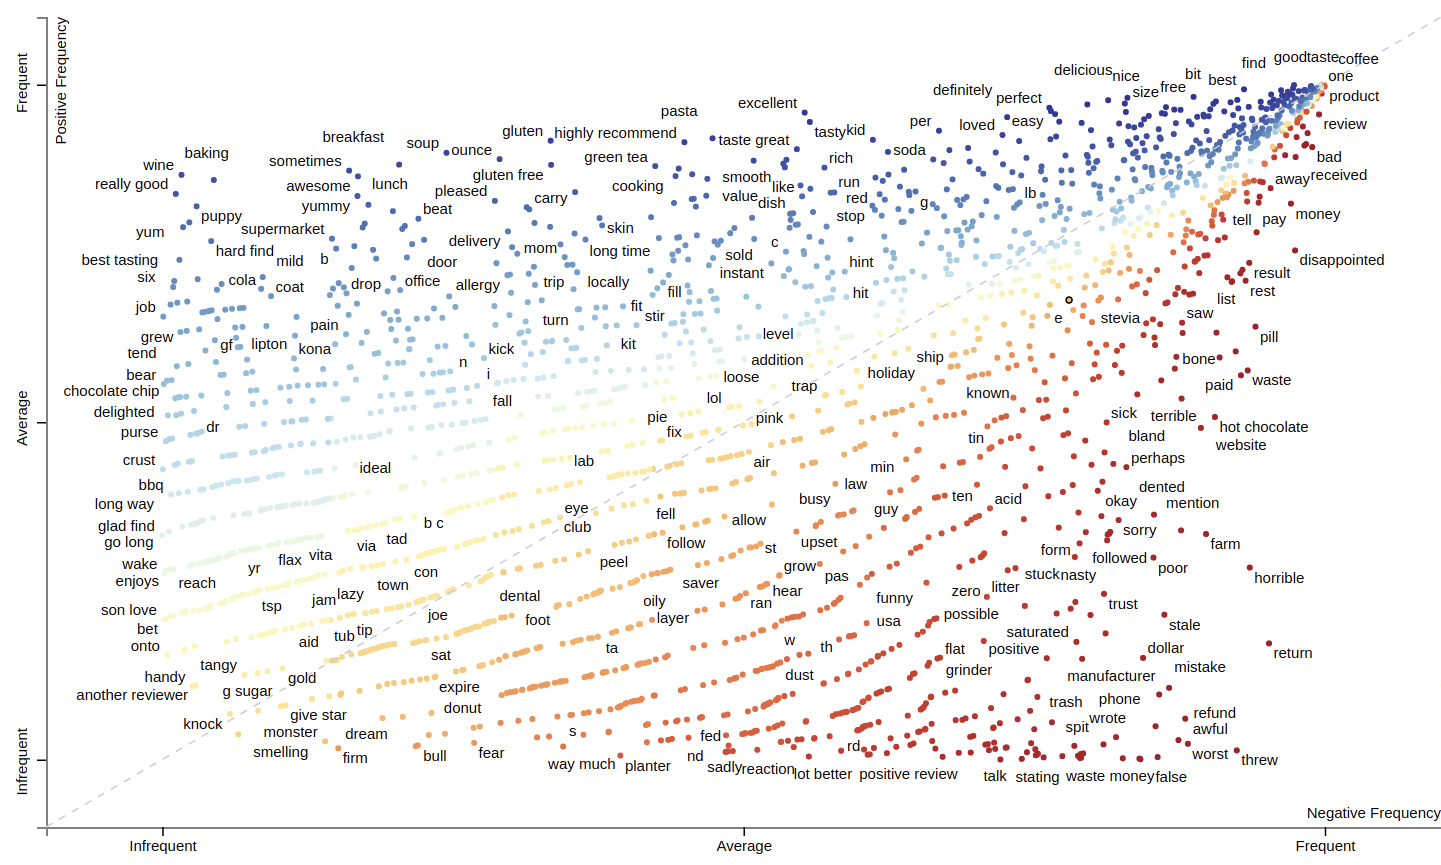

## Create the train and test sets

In [58]:
train_df, test_df = model_selection.train_test_split(
    df, test_size=0.2, random_state=1
)

# Fasttext Embeddings and Text Classification

Fasttext classifier model takes as input the texts themselves and not the embeddings. It does the embeddings internally. That's why we were not able to use the 'Text' columns (RAM was not enough, not even on Colab). So, we used the 'Summary' column for this model.

In [ ]:
cln_df = train_df[["Summary", "sentiment"]].copy()
cln_df.dropna(subset=["Summary"], inplace=True)

In [ ]:
cln_df

Summary  sentiment
398564                   Love that Truvia!          1
319077           Review of Luzianne Coffee          1
14526            Too salty, strange flavor         -1
111931                Better than expected          1
99237           Not sure if this worked...          0
...                                    ...        ...
82069                  standard oolong tea          1
529381  The most amazing jam on the planet          1
434493                     Good Bold Taste          1
357569                    Shockingly sweet         -1
150329                         DELICIOUS!!          1

[315975 rows x 2 columns]

Below we clean the summaries: lower case, remove tags and punctuations and fix contractions.

In [ ]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contraction_dict = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"could've": "could have",
"couldn't": "could not",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"mustn't": "must not",
"needn't": "need not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what's": "what is",
"where'd": "where did",
"where's": "where is",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contraction_dict.keys()))
def expand_contractions(text,contractions_dict=contraction_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

cln_df['Summary'] = cln_df['Summary'].str.lower()
# Expanding Contractions in the reviews
cln_df['Summary']=cln_df['Summary'].apply(lambda x:expand_contractions(x))
cln_df['Summary'] = cln_df['Summary'].apply(lambda x: re.sub('<[^>]*>',' ',x))
cln_df['Summary'] = cln_df['Summary'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ' , x))

In [ ]:
cln_df

Summary  sentiment
398564                   love that truvia           1
319077           review of luzianne coffee          1
14526            too salty  strange flavor         -1
111931                better than expected          1
99237           not sure if this worked             0
...                                    ...        ...
82069                  standard oolong tea          1
529381  the most amazing jam on the planet          1
434493                     good bold taste          1
357569                    shockingly sweet         -1
150329                         delicious            1

[315975 rows x 2 columns]

Split the data into a train (75%) and test sets (25%)

In [ ]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    cln_df["Summary"],
    cln_df.sentiment,
    test_size=0.25,
    random_state=1,
)

In [ ]:
df_train = pd.concat([pd.DataFrame(x_train), pd.DataFrame(y_train)],axis = 1)

We try to make the imbalanced data better by using data augmentation (it wasn't enough, the data was still ibalanced, but it took around 5 hours to generate the new sentences so we couldn't try to generate more)

Augmentation code was taken from this article below.

https://github.com/theartificialguy/NLP-with-Deep-Learning/blob/master/PREPROCESSING%20TECHNIQUES/spam_handling_imbalanced_data.ipynb


In [ ]:
def augmentMyData(df, augmenter, repetitions=1, samples=200, sentiment = 0):
    augmented_texts = []
    # select only the minority class samples
    n_n_df = df[df["sentiment"] == sentiment].reset_index(drop=True) # removes unecessary index column
    for i in tqdm(np.random.randint(0, len(n_n_df), samples)):
        # generating 'n_samples' augmented texts
        for _ in range(repetitions):
            augmented_text = augmenter.augment(n_n_df['Summary'].iloc[i])
            augmented_texts.append(augmented_text)   
    
    data = {
        'sentiment': sentiment,
        'Summary': augmented_texts
    }
    aug_df = pd.DataFrame(data)
    df = shuffle(df.append(aug_df).reset_index(drop=True))
    return df

In [ ]:
augmenter = aug.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")

In [ ]:
aug_df_train = df_train.copy()

In [ ]:
aug_df_train = augmentMyData(aug_df_train, augmenter, samples=40000, sentiment=1)
aug_df_train = augmentMyData(aug_df_train, augmenter, samples=40000, sentiment=0)

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

In [ ]:
df_train["Summary"][90]

'great food for my my dog who has a sensitive stomach '

In [ ]:
augmented_sample_text = augmenter.augment(df_train["Summary"][90])

In [ ]:
augmented_sample_text

'absolutely great dog food... for my my dog who has such a sensitive stomach'

Fasttext code was taken from the notebook below

https://github.com/hminooei/DSbyHadi/blob/master/Tutorial3/sentiment-analysis-embedding.ipynb


Fasttext model requires the input to be in a specific model => We added prefix __ label __ before the labels and also, it did not work with negative labels (-1), so we added the sentiment column by 1. **Now the labels are 0 for negative, 1 for neutral, and 2 for positive reviews.**

In [ ]:
aug_df_train['label'] = aug_df_train.apply(lambda row: '__label__' + str(row.sentiment+1), axis=1) 

In [ ]:
aug_df_train = aug_df_train.drop(['sentiment'], axis=1)

In [ ]:
df_valid = pd.concat([pd.DataFrame(x_valid), pd.DataFrame(y_valid)],axis = 1)
df_valid['label'] = df_valid.apply(lambda row: '__label__' + str(row.sentiment+1), axis=1)
df_valid = df_valid.drop(['sentiment'], axis=1)

In [ ]:
df_valid

Summary       label
437818                                   just plain fun  __label__2
30646                              moist   delicious     __label__2
441544                                           yummy   __label__2
451764  good price  quick delivery  but poor results     __label__0
126584                                 shoulda listened  __label__0
...                                                 ...         ...
221577                            pleasantly surprised   __label__2
139550                         great coffee  but pricy   __label__2
124448                    super healthy not super tasty  __label__1
178179                        returns   expiration date  __label__1
369679                      much better than newmans o   __label__2

[78994 rows x 2 columns]

In [ ]:
train_data = aug_df_train.copy()
valid_data = df_valid.copy()

Fasttext model also takes as input a file and not a dataframe. So here we create 2 files, one for the train data and one for the valid data

In [ ]:
train_data.to_csv(path_or_buf='./sentiment.train', header=False, index=False, sep='\t')
valid_data.to_csv(path_or_buf='./sentiment.valid', header=False, index=False, sep='\t')

In [ ]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p)) #precision
    print("R@{}\t{:.3f}".format(1, r)) #recall

In [ ]:
BASE_PATH = "./"

In [ ]:
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!make
!cp fasttext ../
%cd ..

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.22 MiB | 29.66 MiB/s, done.
Resolving deltas: 100% (2417/2417), done.
/content/fastText
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/args.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/autotune.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/matrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/dictionary.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/loss.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/productquantizer.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/densematrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/quantmatrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-l

In [ ]:
train_data_path = os.path.join(BASE_PATH, 'sentiment.train')
valid_data_path = os.path.join(BASE_PATH, 'sentiment.valid')

# train_supervised(): Will first find word embeddings using input data, 
# then trains a simple model using those ebmeddings. 
# If the pretrained word vectors are given, the neural net's weights 
# used for finding an embedding will be initialized by them (transfer learning)


sentiment_model = train_supervised(
    input=train_data_path,
    lr=0.1,
    dim=100,
    epoch=100,
    minCount=1,
    minCountLabel=0,
    minn=2,
    maxn=3,
    wordNgrams=3,
    loss="hs", 
    bucket=1500000,
    lrUpdateRate=100,
    t=1e-4,
    label="__label__",
    # pretrainedVectors="gdrive/My Drive/final/wiki-news-300d-1M-subword.vec"
)
print("On train")
print_results(*sentiment_model.test(train_data_path))
print("On valid")
print_results(*sentiment_model.test(valid_data_path))
sentiment_model.save_model("sentiment_model.bin")

On train
N	316981
P@1	0.979
R@1	0.979
On valid
N	78994
P@1	0.846
R@1	0.846


We run the model on "neutral nothing special", and it should give us the neutral label 1:

this model outputs a list of probabilities of each of the labels. If i choose k=3, it would output the whole list.

In [ ]:
pr=sentiment_model.predict("neutral nothing special ", k=1)

In [ ]:
pr

(('__label__1',), array([0.9861086]))

In [ ]:
def get_pred(doc):
    pr = sentiment_model.predict(doc, k=1)
    return(str(pr[0])[11]) #character 11 will give us the class

In [ ]:
valid_data['prediction'] = valid_data['Summary'].apply(get_pred)
valid_data['orig_label'] = valid_data['label'].apply(lambda row: row[-1:])

In [ ]:
print(metrics.recall_score(valid_data['orig_label'], valid_data['prediction'], average='macro'))
print(metrics.accuracy_score(valid_data['orig_label'], valid_data['prediction']))
print(metrics.f1_score(valid_data['orig_label'], valid_data['prediction'], average='macro'))

0.6396421588148637
0.8455578904726941
0.6443832076349686


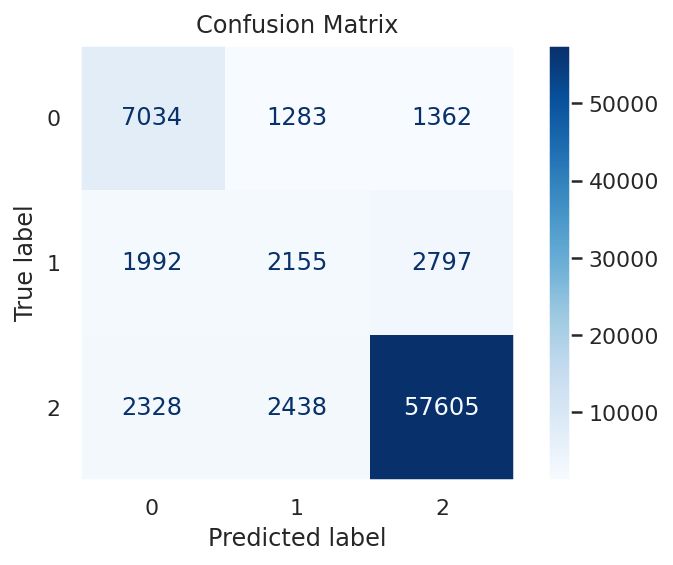

In [ ]:
disp = metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(valid_data['prediction'], valid_data['orig_label'])
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

On test set (we do the same steps we did above to have the test set with the same format and erquirements of the model):

In [ ]:
#cleaning the test set
test_df['Summary'] = test_df['Summary'].str.lower()
test_df['Summary']=test_df['Summary'].apply(lambda x:expand_contractions(str(x)))
test_df['Summary'] = test_df['Summary'].apply(lambda x: re.sub('<[^>]*>',' ',x))
test_df['Summary'] = test_df['Summary'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ' , x))

In [ ]:
test_df['label'] = test_df.apply(lambda row: '__label__' + str(row.sentiment+1), axis=1) 

In [ ]:
x_test = test_df["Summary"].squeeze()
y_test = test_df["label"].squeeze()

In [ ]:
d_test = {'Summary':x_test,'label':y_test}
test_data = pd.DataFrame(d_test)

In [ ]:
test_data.to_csv(path_or_buf='./sentiment.test', header=False, index=False, sep='\t')

In [ ]:
test_data_path = os.path.join(BASE_PATH, 'sentiment.test')

In [ ]:
print("On test")
print_results(*sentiment_model.test(test_data_path))

On test
N	78994
P@1	0.843
R@1	0.843


In [ ]:
test_data['prediction'] = test_data['Summary'].apply(get_pred)
test_data['orig_label'] = test_data['label'].apply(lambda row: row[-1:])

In [ ]:
test_data['prediction']

133520    2
398096    2
237551    2
159523    1
28377     2
         ..
467245    2
452035    2
103591    2
416747    2
23174     1
Name: prediction, Length: 78994, dtype: object

In [ ]:
from sklearn import metrics

print(metrics.recall_score(test_data['orig_label'], test_data['prediction'], average='macro'))
print(metrics.accuracy_score(test_data['orig_label'], test_data['prediction']))
print(metrics.f1_score(test_data['orig_label'], test_data['prediction'], average='macro'))

0.6403578569482686
0.8432412588297845
0.6452530199538206


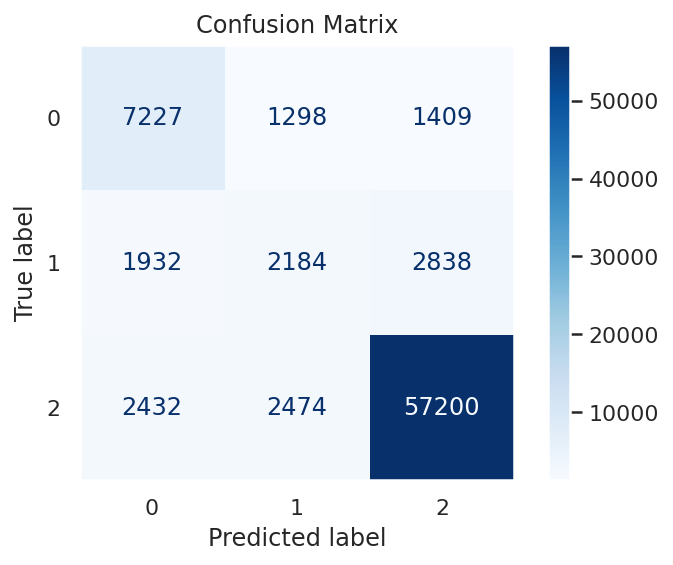

In [ ]:
disp = metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(test_data['prediction'], test_data['orig_label'])
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


# BERT embeddings

In [ ]:
PRE_TRAINED_MODEL_NAME = "bert-base-cased"
tokenizer = BertTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME)

Check how the tokenizer works:

In [ ]:
sample_txt = df.iloc[0]["Text"]
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
   Tokens: ['I', 'have', 'bought', 'several', 'of', 'the', 'Vita', '##lity', 'can', '##ned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', '.', 'The', 'product', 'looks', 'more', 'like', 'a', 'stew', 'than', 'a', 'processed', 'meat', 'and', 'it', 'smells', 'better', '.', 'My', 'Labrador', 'is', 'fin', '##ick', '##y', 'and', 'she', 'appreciate', '##s', 'this', 'product', 'better', 'than', 'most', '.']
Token IDs: [146, 1138, 3306, 1317, 1104, 1103, 25118, 11796, 1169, 3540, 3676, 2094, 2982, 1105, 1138, 1276, 1172, 1155, 1106, 1129, 1104, 1363, 3068, 119, 1109, 3317, 2736, 1167, 1176, 170, 26036, 1190, 170, 14659, 6092, 1105, 1122, 16533, 1618, 119, 1422, 20255,

**Tokenizing with Bert tokenizer the whole dataframe**

Input ids and attention masks have size [1,150]

In [ ]:
def fastTokenizerBert(row):
    encoding = tokenizer.encode_plus(row["Text"],
                                     max_length=150, #number of tokens and attention mask elements
                                     padding="max_length",
                                     truncation=True,
                                     return_tensors="pt")
    row["input_ids"] = encoding["input_ids"]
    row["attention_mask"] = encoding["attention_mask"]
    return row

For the meantime, we are going to use only the 20% for BERT for a faster runtime.

In [ ]:
new_train_df = test_df.apply(fastTokenizerBert, axis=1)

In [ ]:
new_train_df.head(2)

Unnamed: 0  ...                                     attention_mask
115375      133520  ...  [[tensor(1), tensor(1), tensor(1), tensor(1), ...
290549      398096  ...  [[tensor(1), tensor(1), tensor(1), tensor(1), ...

[2 rows x 8 columns]

In [ ]:
# Instantiate model and move it to the GPU
model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Create tensor dataset and move to GPU**

In [ ]:
train_inputs_tensors = torch.concat(list(new_train_df["input_ids"].values))
train_masks_tensors = torch.concat(list(new_train_df["attention_mask"].values))

test_inputs_tensors = torch.concat(list(new_test_df["input_ids"].values))
test_masks_tensors = torch.concat(list(new_test_df["attention_mask"].values))

In [ ]:
# Convert to tensor dataset
# DataLoaders gives an iterator
train_data = TensorDataset(train_inputs_tensors, train_masks_tensors)
train_dataloader = DataLoader(train_data, batch_size=16)

test_data = TensorDataset(test_inputs_tensors, test_masks_tensors)
test_dataloader = DataLoader(test_data, batch_size=32)

**Bert embeddings for train set**

In [ ]:
bert_features_arr = []
start_time = time.time()
for batch in train_dataloader:
  # Send data to GPU
  input_ids_gpu = batch[0].to(device)
  attention_mask_gpu = batch[1].to(device)
  # Model returns object with keys
  model_output = model(
    input_ids = input_ids_gpu,
    attention_mask = attention_mask_gpu
  )
  bert_ft_batch = model_output.last_hidden_state[:, 0, :].cpu().detach().numpy()
  bert_features_arr.append(bert_ft_batch)

runtime = time.time()-start_time
print("Model trained in %s seconds" % (runtime))

Model trained in 1914.7494320869446 seconds


In [18]:
bert_features = np.concatenate(bert_features_arr, axis=0)
print(bert_features.shape)

(78994, 768)


### Train and test split
Do a split of 50-50 of train and test sets

In [ ]:
target = test_df["sentiment"].to_numpy() 
X_train, X_test, y_train, y_test = model_selection.train_test_split(bert_features, 
                                                                    target, 
                                                                    stratify=target, 
                                                                    test_size=0.4, 
                                                                    random_state=1)

**Distribution of target feature in the train set**

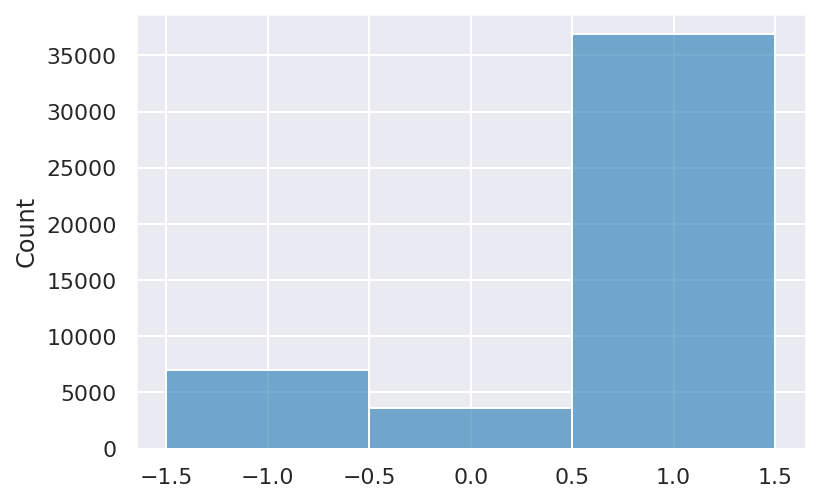

In [29]:
sns.histplot(y_train, alpha=0.6, discrete=True)
plt.show()

**Distribution of target feature in the test set**

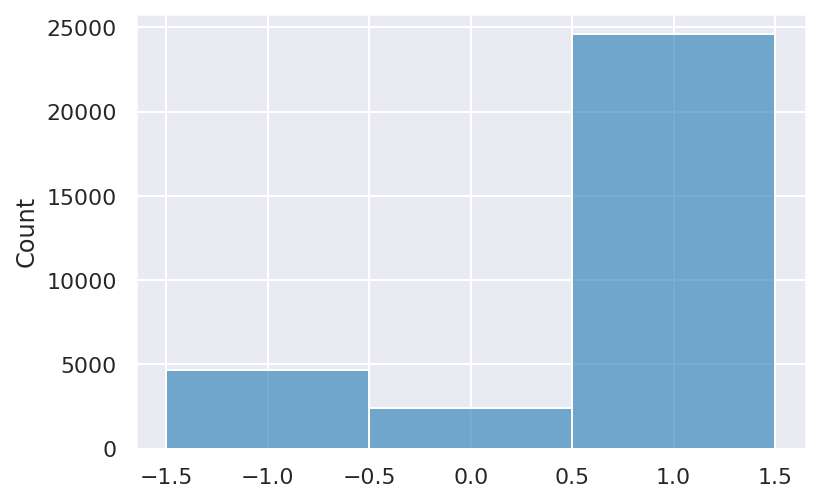

In [30]:
sns.histplot(y_test, alpha=0.6, discrete=True)
plt.show()

### Create a validation set
Make a new split over the train data, to get a validation set too.  
**Train set** 80%  
**Test set** 20%

In [31]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_valid.shape)

(37916, 768)
(9480, 768)


### Linear classifier with Stochastic Gradient Descent

In [32]:
clf = linear_model.SGDClassifier(class_weight="balanced", loss="log", random_state=1)
start_time = time.time()
clf.fit(X_train, y_train)
runtime = time.time()-start_time
print("Linear model trained in %s seconds" % (runtime))

Linear model trained in 21.380367755889893 seconds


**Performance on validation set**

In [33]:
# Predict
y_pred = clf.predict(X_valid)

# Performance 
metrics.confusion_matrix(y_pred, y_valid)
print(metrics.classification_report(y_pred, y_valid))

              precision    recall  f1-score   support

          -1       0.35      0.76      0.48       649
           0       0.56      0.22      0.32      1829
           1       0.87      0.92      0.89      7002

    accuracy                           0.77      9480
   macro avg       0.59      0.63      0.56      9480
weighted avg       0.78      0.77      0.75      9480



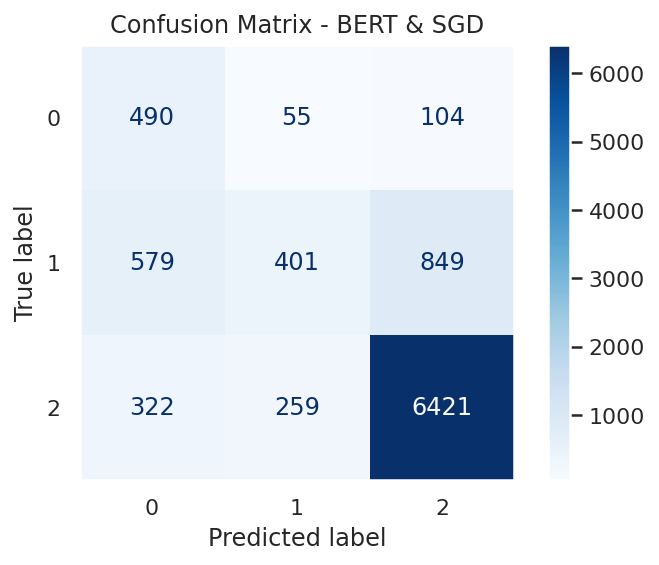

In [34]:
disp = metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(y_pred, y_valid)
)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.title("Confusion Matrix - BERT & SGD")
plt.show()

**Performance on test set**

In [35]:
# Test prediction
y_pred = clf.predict(X_test)

# Performance 
metrics.confusion_matrix(y_pred, y_test)
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

          -1       0.34      0.76      0.47      2101
           0       0.58      0.23      0.32      6129
           1       0.87      0.92      0.89     23368

    accuracy                           0.77     31598
   macro avg       0.60      0.63      0.56     31598
weighted avg       0.78      0.77      0.76     31598



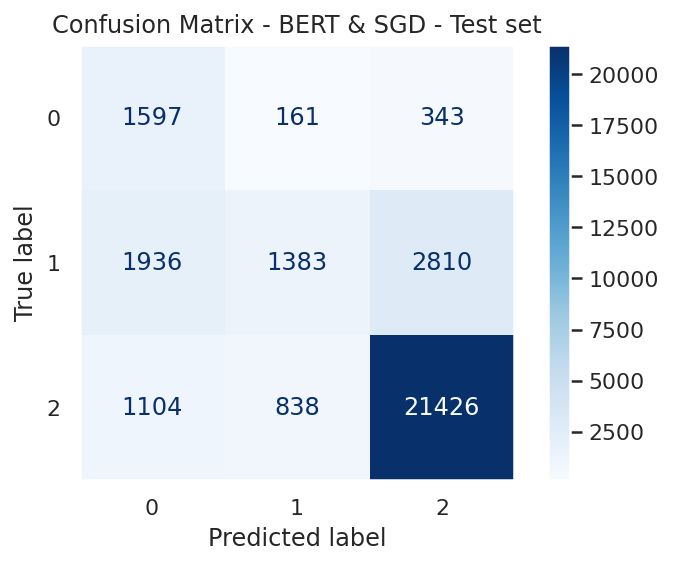

In [36]:
disp = metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(y_pred, y_test)
)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.title("Confusion Matrix - BERT & SGD - Test set")
plt.show()